In [1]:
#import required modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from seqfold import dg
import matplotlib.pyplot as plt
from scipy.stats import anderson, wilcoxon, ttest_ind

In [2]:
numts=pd.read_csv('/Volumes/motilin/balint/numt/mice_strains_numt/csvs/Mus_musculus_numts.csv')

In [3]:
mt_annot=pd.read_csv('/Volumes/motilin/balint/numt/mice_strains_numt/mt_annotations/mm.bed',
                    sep='\t',header=None)
mt_annot.columns=['MT','start','end','name','sig','strand']
mt_annot['length']=mt_annot.apply(lambda row: row['end']-row['start'],axis=1)

In [4]:
mt_trnas=mt_annot.loc[mt_annot['name'].str.contains('trn')]
trna_ranges=mt_trnas.apply(lambda row: np.arange(row['start'],row['end']),axis=1)
trna_ranges.index=mt_annot.loc[mt_annot['name'].str.contains('trn')]['name']
trna_ranges

name
trnF(ttc)     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
trnV(gta)     [1024, 1025, 1026, 1027, 1028, 1029, 1030, 103...
trnL2(tta)    [2675, 2676, 2677, 2678, 2679, 2680, 2681, 268...
trnI(atc)     [3705, 3706, 3707, 3708, 3709, 3710, 3711, 371...
trnQ(caa)     [3771, 3772, 3773, 3774, 3775, 3776, 3777, 377...
trnM(atg)     [3844, 3845, 3846, 3847, 3848, 3849, 3850, 385...
trnW(tga)     [4949, 4950, 4951, 4952, 4953, 4954, 4955, 495...
trnA(gca)     [5017, 5018, 5019, 5020, 5021, 5022, 5023, 502...
trnN(aac)     [5088, 5089, 5090, 5091, 5092, 5093, 5094, 509...
trnC(tgc)     [5191, 5192, 5193, 5194, 5195, 5196, 5197, 519...
trnY(tac)     [5259, 5260, 5261, 5262, 5263, 5264, 5265, 526...
trnS2(tca)    [6869, 6870, 6871, 6872, 6873, 6874, 6875, 687...
trnD(gac)     [6941, 6942, 6943, 6944, 6945, 6946, 6947, 694...
trnK(aaa)     [7699, 7700, 7701, 7702, 7703, 7704, 7705, 770...
trnG(gga)     [9390, 9391, 9392, 9393, 9394, 9395, 9396, 939...
trnR(cga)     [9807, 9808, 9809, 98

In [5]:
numt_ranges=numts.sort_values(by='mt_start').apply(lambda row: np.arange(row['mt_start'],row['mt_start']+row['mt_length']),axis=1)
numt_ranges

0      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
36     [231, 232, 233, 234, 235, 236, 237, 238, 239, ...
79     [273, 274, 275, 276, 277, 278, 279, 280, 281, ...
62     [299, 300, 301, 302, 303, 304, 305, 306, 307, ...
97     [335, 336, 337, 338, 339, 340, 341, 342, 343, ...
                             ...                        
131    [16069, 16070, 16071, 16072, 16073, 16074, 160...
122    [16107, 16108, 16109, 16110, 16111, 16112, 161...
153    [16249, 16250, 16251, 16252, 16253, 16254, 162...
94     [32142, 32143, 32144, 32145, 32146, 32147, 321...
99     [32328, 32329, 32330, 32331, 32332, 32333, 323...
Length: 154, dtype: object

In [6]:
trna_ranges

name
trnF(ttc)     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
trnV(gta)     [1024, 1025, 1026, 1027, 1028, 1029, 1030, 103...
trnL2(tta)    [2675, 2676, 2677, 2678, 2679, 2680, 2681, 268...
trnI(atc)     [3705, 3706, 3707, 3708, 3709, 3710, 3711, 371...
trnQ(caa)     [3771, 3772, 3773, 3774, 3775, 3776, 3777, 377...
trnM(atg)     [3844, 3845, 3846, 3847, 3848, 3849, 3850, 385...
trnW(tga)     [4949, 4950, 4951, 4952, 4953, 4954, 4955, 495...
trnA(gca)     [5017, 5018, 5019, 5020, 5021, 5022, 5023, 502...
trnN(aac)     [5088, 5089, 5090, 5091, 5092, 5093, 5094, 509...
trnC(tgc)     [5191, 5192, 5193, 5194, 5195, 5196, 5197, 519...
trnY(tac)     [5259, 5260, 5261, 5262, 5263, 5264, 5265, 526...
trnS2(tca)    [6869, 6870, 6871, 6872, 6873, 6874, 6875, 687...
trnD(gac)     [6941, 6942, 6943, 6944, 6945, 6946, 6947, 694...
trnK(aaa)     [7699, 7700, 7701, 7702, 7703, 7704, 7705, 770...
trnG(gga)     [9390, 9391, 9392, 9393, 9394, 9395, 9396, 939...
trnR(cga)     [9807, 9808, 9809, 98

In [7]:
def tRNA_numt(tRNA_range):
    trial=[]
    for numt_range in numt_ranges:
        if len(set(tRNA_range)&set(numt_range))>1:
            common_elements=list(set(tRNA_range)&set(numt_range))
            common_elements.sort()
            first_element=common_elements[0]
            last_element=common_elements[-1]
            numt_range=list(numt_range)
            numt_range.sort()
            trial.append((numt_range.index(first_element),numt_range.index(last_element)))
        else:
            trial.append(np.nan)
    return pd.Series(trial)

In [8]:
intersections=trna_ranges.apply(tRNA_numt)
intersections.columns=numt_ranges.index.values
intersections=intersections.dropna(how='all',axis=1)
intersections['trna_length']=trna_ranges.apply(lambda trna_range:len(trna_range))
intersections=intersections.drop(labels=[0],axis=1)
intersections

,85,72,11,34,35,76,3,14,44,30,...,119,1,86,4,25,20,5,64,6,trna_length
name,,,,,,,,,,,,,,,,,,,,,
trnF(ttc),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68
trnV(gta),"(228, 296)","(0, 25)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69
trnL2(tta),NaN,NaN,"(721, 795)","(165, 172)","(0, 65)",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75
trnI(atc),NaN,NaN,NaN,NaN,NaN,"(807, 875)","(507, 575)","(312, 380)","(124, 192)","(48, 116)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69
trnQ(caa),NaN,NaN,NaN,NaN,NaN,"(873, 943)","(573, 643)","(378, 428)","(190, 245)","(114, 184)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71
trnM(atg),NaN,NaN,NaN,NaN,NaN,"(946, 954)","(646, 714)",NaN,NaN,"(187, 255)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69
trnW(tga),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67
trnA(gca),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69
trnN(aac),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71


In [9]:
#get the numt sequences which corresponding to the given trnas
def get_numt_seq(row):
    numt_sequences=[]
    for index,element in enumerate(row):
        if type(element)==tuple:
            numt_index=intersections.columns.values[index]
            numt_sequence=numts.loc[numt_index]['g_sequence'][element[0]:element[1]].replace('-','').upper()
            numt_sequences.append(numt_sequence)
    numt_sequences.sort(reverse=True,key=len)
    return numt_sequences
    
numt_sequences=intersections.apply(get_numt_seq,axis=1)
numt_sequences

name
trnF(ttc)                                                    []
trnV(gta)     [TTTAGTATTTTATCTTCAATTATTCCTGAGAGTGGGTATTAGAAT...
trnL2(tta)    [GCAGATCATGCAAAATGCTGAGTACTTAAAACTTTGTTCTTAGAG...
trnI(atc)     [GGTTAGGGCTCCGAGGCATAGTATAGTTGTTAAAATAAAGTTATT...
trnQ(caa)     [TCGGACCAGTAGAAAGATTCCTGCAACTACTATTGTACTTGAGTG...
trnM(atg)     [CCTTATCCTAACATCGGAAGATCAGCTAATTAAGCTATCGGGCCC...
trnW(tga)     [AGTAATTTAGGATATTCTAGTCCAAGAGCCTTCAAAGCCCTAAGA...
trnA(gca)     [TAAGGACTGTAAGACTCTATCCTAAATCTATTGAATGCAAATCAA...
trnN(aac)     [ACTAGATTGGCAGGAATCAAACCTACGAAAATGTAATTAACAGCT...
trnC(tgc)     [GGGACAGGAGAAGCCTTGGTAAAGTTATTTTTTTTCCTACTCTTT...
trnY(tac)     [TTCATGCCAGCTCTTGGTAAGAAGAGGACTTAAAGCTTTGTATTT...
trnS2(tca)    [ACTAATTGGAAGTCAGTTATATTAATTATACTAAGGGAGTAAGAT...
trnD(gac)     [AAAAGTCAGACTACGTCTACAAAATGTCAGTATCATGCTGCGGCT...
trnK(aaa)     [TTATCATGTAGATATAGGCTTACTAGGAGGGTGAATACGTAGGCT...
trnG(gga)     [TTGAAACCAATTTTAGGGGGTTCGATTCCTTCCTTTCTTATTTTA...
trnR(cga)     [TAGCAAACACTGCTCCCATT

In [10]:
#get mitochondrial sequence
mt_seq=''
for seq_record in SeqIO.parse('/Volumes/motilin/balint/numt/mice_strains_numt/mt_fastas/Mus_musculus.fa', "fasta"):
    mt_seq=str(seq_record.seq)

#get tRNA sequences based on annotation
trna_sequences=mt_trnas.apply(lambda row: mt_seq[row['start']:row['end']],axis=1)
trna_sequences.index=mt_trnas['name']
trna_sequences=trna_sequences.apply(lambda sequence:sequence.replace('T','U'))
trna_sequences

name
trnF(ttc)     GUUAAUGUAGCUUAAUAACAAAGCAAAGCACUGAAAAUGCUUAGAU...
trnV(gta)     CAUAGUGUAGCUUAAUAUUAAAGCAUCUGGCCUACACCCAGAAGAU...
trnL2(tta)    AUUAGGGUGGCAGAGCCAGGAAAUUGCGUAAGACUUAAAACCUUGU...
trnI(atc)     AGAAAUAUGUCUGAUAAAAGAAUUACUUUGAUAGAGUAAAUUAUAG...
trnQ(caa)     CUAGGACAAUAGGAAUUGAACCUACACUUAAGAAUUCAAAAUUCUC...
trnM(atg)     AGUAAGGUCAGCUAAUUAAGCUAUCGGGCCCAUACCCCGAAAACGU...
trnW(tga)     AGAAGUUUAGGAUAUACUAGUCCGCGAGCCUUCAAAGCCCUAAGAA...
trnA(gca)     UAAGGACUGUAAGACUUCAUCCUACAUCUAUUGAAUGCAAAUCAAU...
trnN(aac)     CUAGAUUGGCAGGAAUUAAACCUACGAAAAUUUAGUUAACAGCUAA...
trnC(tgc)     AAGUCUUAGUAGAGAUUUCUCUACACCUUCGAAUUUGCAAUUCGAC...
trnY(tac)     UGGUAAAAAGAGGAUUUAAACCUCUGUGUUUAGAUUUACAGUCUAA...
trnS2(tca)    UAAGAAAGGAAGGAAUCGAACCCCCUAAAAUUGGUUUCAAGCCAAU...
trnD(gac)     AAGAUAUUAGUAAAAUCAAUUACAUAACUUUGUCAAAGUUAAAUUA...
trnK(aaa)     CACUAUGAAGCUAAGAGCGUUAACCUUUUAAGUUAAAGUUAGAGAC...
trnG(gga)     ACUCCCUUAGUAUAAUUAAUAUAACUGACUUCCAAUUAGUAGAUUC...
trnR(cga)     UGGUAAUUAGUUUAAAAAAAA

In [11]:
numt_sequences=numt_sequences.drop('trnF(ttc)')

In [12]:
longest_numt_sequences=numt_sequences.apply(lambda sequences:sequences[0])
longest_numt_sequences=longest_numt_sequences.apply(lambda sequence:sequence.replace('T','U'))
longest_numt_sequences

name
trnV(gta)     UUUAGUAUUUUAUCUUCAAUUAUUCCUGAGAGUGGGUAUUAGAAUU...
trnL2(tta)    GCAGAUCAUGCAAAAUGCUGAGUACUUAAAACUUUGUUCUUAGAGG...
trnI(atc)     GGUUAGGGCUCCGAGGCAUAGUAUAGUUGUUAAAAUAAAGUUAUUA...
trnQ(caa)     UCGGACCAGUAGAAAGAUUCCUGCAACUACUAUUGUACUUGAGUGU...
trnM(atg)     CCUUAUCCUAACAUCGGAAGAUCAGCUAAUUAAGCUAUCGGGCCCA...
trnW(tga)     AGUAAUUUAGGAUAUUCUAGUCCAAGAGCCUUCAAAGCCCUAAGAA...
trnA(gca)     UAAGGACUGUAAGACUCUAUCCUAAAUCUAUUGAAUGCAAAUCAAU...
trnN(aac)     ACUAGAUUGGCAGGAAUCAAACCUACGAAAAUGUAAUUAACAGCUA...
trnC(tgc)     GGGACAGGAGAAGCCUUGGUAAAGUUAUUUUUUUUCCUACUCUUUU...
trnY(tac)     UUCAUGCCAGCUCUUGGUAAGAAGAGGACUUAAAGCUUUGUAUUUA...
trnS2(tca)    ACUAAUUGGAAGUCAGUUAUAUUAAUUAUACUAAGGGAGUAAGAUC...
trnD(gac)     AAAAGUCAGACUACGUCUACAAAAUGUCAGUAUCAUGCUGCGGCUU...
trnK(aaa)     UUAUCAUGUAGAUAUAGGCUUACUAGGAGGGUGAAUACGUAGGCUU...
trnG(gga)     UUGAAACCAAUUUUAGGGGGUUCGAUUCCUUCCUUUCUUAUUUUAC...
trnR(cga)     UAGCAAACACUGCUCCCAUUGAUAGAACAUAGUGGAAAUGGGCUAC...
trnH(cac)     AGUGUUGCUAUGAUUAGACAG

In [13]:
numt_Gs=longest_numt_sequences.apply(lambda sequence: dg(sequence,temp=37))
numt_Gs

name
trnV(gta)    -13.5
trnL2(tta)   -16.4
trnI(atc)     -5.5
trnQ(caa)    -22.4
trnM(atg)    -11.7
trnW(tga)    -12.8
trnA(gca)     -7.3
trnN(aac)    -11.5
trnC(tgc)    -11.4
trnY(tac)    -11.4
trnS2(tca)    -8.1
trnD(gac)    -16.2
trnK(aaa)    -11.6
trnG(gga)     -9.6
trnR(cga)    -10.6
trnH(cac)     -6.5
trnS1(agc)    -6.7
trnL1(cta)    -5.3
trnE(gaa)     -8.5
trnT(aca)    -14.0
trnP(cca)    -15.6
dtype: float64

In [14]:
Gs_df=pd.DataFrame(
    data=[len(numt_Gs)*['numt'],numt_Gs],
    columns=numt_Gs.index,
    index=['trna_or_numt','deltaG']
).T

In [15]:
trna_Gs=trna_sequences.apply(lambda sequence: dg(sequence, temp=37))
trna_Gs=pd.DataFrame(
    data=[len(trna_Gs)*['tRNA'],trna_Gs],
    columns=trna_Gs.index,
    index=['trna_or_numt','deltaG']
).T

In [16]:
Gs_df=pd.concat([trna_Gs,Gs_df])
Gs_df['name']=Gs_df.index
Gs_df

,trna_or_numt,deltaG,name
name,,,
trnF(ttc),tRNA,-11.9,trnF(ttc)
trnV(gta),tRNA,-19.4,trnV(gta)
trnL2(tta),tRNA,-26.8,trnL2(tta)
trnI(atc),tRNA,-14.2,trnI(atc)
trnQ(caa),tRNA,-16.6,trnQ(caa)
trnM(atg),tRNA,-18.1,trnM(atg)
trnW(tga),tRNA,-12.2,trnW(tga)
trnA(gca),tRNA,-16.4,trnA(gca)
trnN(aac),tRNA,-13.6,trnN(aac)


In [17]:
#normality testing
trna_normality=anderson(trna_Gs['deltaG'].tolist())
trna_stat=trna_normality[0]
trna_critical_value=trna_normality[1][2]

numts_normality=anderson(numt_Gs)
numts_stat=numts_normality[0]
numts_critical_value=numts_normality[1][2]

In [18]:
#statistics (normality testing and significance)
#numt vs genome
if (numts_stat > numts_critical_value) or (trna_stat > trna_critical_value):
    significance = wilcoxon(trna_Gs['deltaG'].tolist(), numt_Gs)
else:
    significance = ttest_ind(trna_Gs['deltaG'].tolist(), numt_Gs)
significance[1]

0.00010023543080460478

In [19]:
#create a function for the statistical annotation of the graph
def statistical_annotation(data, significance, positions, height, rounding):
    x1, x2 = positions[0],positions[1]
    maximum = max([max(data[0]),max(data[1])])
    y, h, col = maximum + height + 0.8, 0.8, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c = col)
    if significance < 0.05:
        plt.text((x1+x2)*.5, y+h, '$\it{P}$ ~ %s' % np.round(significance,rounding), ha='center',
                 va='bottom', color = col, fontsize = 20)
    else:
        plt.text((x1+x2)*.5, y+h, "n.s.", ha='center', va='bottom', color = col, fontsize = 20)

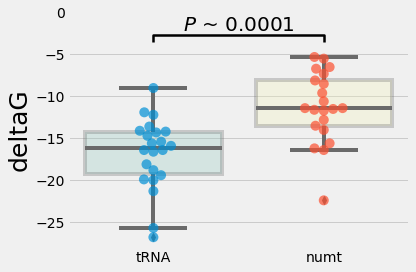

In [30]:
plt.style.use('fivethirtyeight')
ax=sns.boxplot(
    x='trna_or_numt',
    y='deltaG',
    data=Gs_df,
    palette="Set3",
    boxprops=dict(alpha=.3)
)
ax=sns.swarmplot(
    x='trna_or_numt',
    y='deltaG',
    data=Gs_df,
    size=10,
    alpha=0.7
)
ax.set_ylim(-28,0)
ax.set_xlabel('')
ax.set_ylabel('deltaG',fontsize=25)
statistical_annotation([trna_Gs['deltaG'].tolist(), numt_Gs],significance[1],[0,1],1,rounding=5)
plt.tight_layout()
plt.savefig('../../results/deltaGs.png',dpi=200)